In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import pandas_profiling
import sys,os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas.api.types as ptypes
from numpy.random import choice
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import random
from random import randrange
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import  matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')



import statsmodels.api as sm

## Can we leverage well-known feature selection strategies, such as Chi-squared ranking, toselect features that are more data-error robust?

Let's collect some statistics about every feature before corrupting the data. 


**Chi square** is a non-parametric test that is used to show association between two qualitative variables (like gender and eye color), while **correlation** (Pearson coefficient) is used to test the correlation between two quantitative variables (like heart rate and blood pressure)

In the given dataset we have only quantitative data 

In [2]:
df=pd.read_csv('./amit/data.csv')
print(df.columns)
df.head()
df.shape

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


(569, 32)

In [3]:
def load_data():
    df=pd.read_csv('./amit/data.csv')
    df['diagnosis'] =df['diagnosis'].apply(lambda x: 1 if x =="M" else 0)
    y = df['diagnosis']
    X = df.drop(['diagnosis','id'],axis=1)
    return X,y
X,y =load_data()
feature_cols = X.columns.to_list()

In [4]:
feature_stats = X.describe().T[['mean','std','max','min']]
df['diagnosis'] =df['diagnosis'].apply(lambda x: 1 if x =="M" else 0)
corr_matrix = df.corr()


In [5]:


model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 3)
fit = rfe.fit(X, y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
ranking_names =map(lambda x: feature_cols[x],fit.ranking_)
print("Feature Ranking: %s" % list(ranking_names))

Num Features: 3
Selected Features: [False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False  True  True False False]
Feature Ranking: ['compactness_mean', 'texture_se', 'perimeter_worst', 'concavity_worst', 'texture_worst', 'symmetry_mean', 'area_mean', 'concave points_mean', 'compactness_se', 'compactness_worst', 'texture_mean', 'fractal_dimension_mean', 'concavity_mean', 'smoothness_se', 'symmetry_worst', 'perimeter_se', 'area_se', 'area_worst', 'smoothness_worst', 'concave points_worst', 'symmetry_se', 'radius_se', 'concave points_se', 'radius_worst', 'fractal_dimension_se', 'perimeter_mean', 'texture_mean', 'texture_mean', 'smoothness_mean', 'concavity_se']


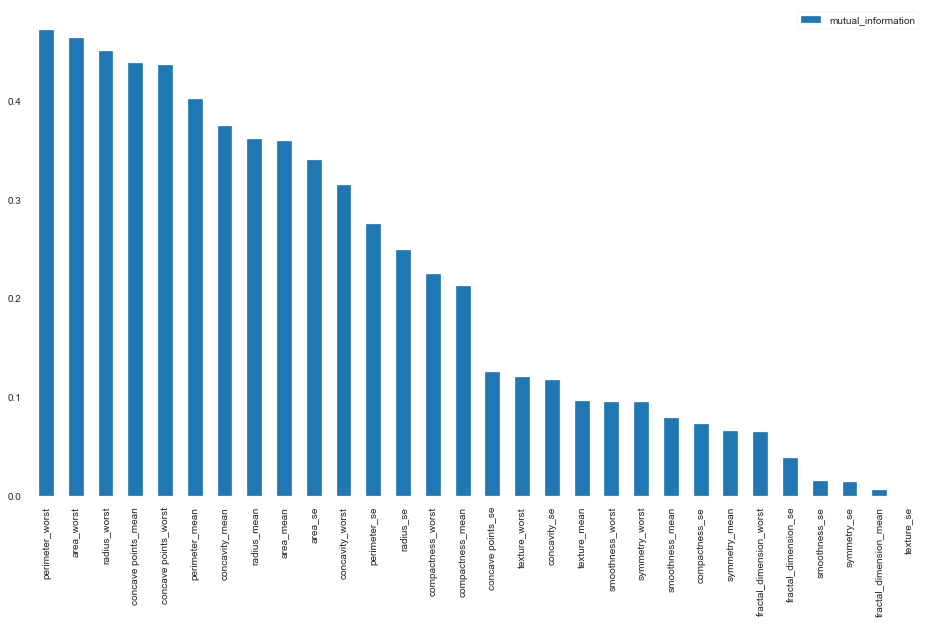

In [6]:
mutual_info = np.array(mutual_info_classif(X, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=42))

mutual_info= pd.DataFrame(mutual_info,columns=["mutual_information"],index=feature_cols)

mutual_info.sort_values(by='mutual_information',ascending=False)\
        .plot(kind='bar',figsize=(16,9))

In [7]:
from DataCorruption.DataCorruptor import DataCorruptor


           A   B    C     D
0  30.000000  20  0.1  lmao
1   1.181524  50  0.5   omf
2  15.000000  30  0.2      
   A  B  C  D
0  0  0  0  0
1  1  0  0  1
2  0  0  0  1


In [8]:
    
data_corruptor = DataCorruptor(X,feature_cols)
data_corruptor.get_dataset_with_corrupted_col('radius_mean')

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.645716,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,18.910980,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,NaN,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,14.848956,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,31.176230,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,19.416064,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,21.658304,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,15.831844,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,29.998192,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [9]:
#implement featureimportances attributes in random forest  to see the importance of a feature 
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(X,y)
importances = clr_rf_5.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print(" The RandomForest Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s  (%f)" % (indices[f],feature_cols[indices[f]], importances[indices[f]]))

 The RandomForest Feature ranking:
20. radius_worst  (0.124786)
7. concave points_mean  (0.119884)
27. concave points_worst  (0.119792)
23. area_worst  (0.115058)
22. perimeter_worst  (0.107982)
2. perimeter_mean  (0.058554)
0. radius_mean  (0.051143)
3. area_mean  (0.046432)
13. area_se  (0.032769)
26. concavity_worst  (0.029141)
12. perimeter_se  (0.025418)
6. concavity_mean  (0.020956)
1. texture_mean  (0.020200)
21. texture_worst  (0.017373)
10. radius_se  (0.015434)
28. symmetry_worst  (0.011528)
25. compactness_worst  (0.011303)
24. smoothness_worst  (0.010470)
29. fractal_dimension_worst  (0.007872)
17. concave points_se  (0.007339)
5. compactness_mean  (0.007318)
15. compactness_se  (0.005708)
19. fractal_dimension_se  (0.005063)
4. smoothness_mean  (0.004996)
11. texture_se  (0.004658)
8. symmetry_mean  (0.004364)
14. smoothness_se  (0.004222)
18. symmetry_se  (0.004168)
16. concavity_se  (0.003857)
9. fractal_dimension_mean  (0.002210)


In [10]:
# This function returns you a pippeline for specified features repesentation 
def get_pipeline(X):
# We create the preprocessing pipelines for both numeric and categorical data.
    numeric_features = X.select_dtypes(include="number").columns.to_list()#['age', 'fare']
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_features = X.select_dtypes(include="object").columns.to_list()
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])
    return clf 

top_5_rfe =['area_mean', 'concavity_mean', 'area_se', 'concavity_worst',
       'symmetry_worst']

top_10_rfe = ['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean',
       'fractal_dimension_mean', 'area_se', 'concavity_se', 'smoothness_worst',
       'concavity_worst', 'symmetry_worst']

top_5_error_ranking= ['texture_mean','radius_mean','perimeter_mean','area_mean','fractal_dimension_mean']
top_10_error_ranking= ['texture_mean','radius_mean','perimeter_mean','area_mean','fractal_dimension_mean',
                       'compactness_mean','smoothness_mean','concave points_mean','concavity_mean','symmetry_mean']

clf = get_pipeline(X)
clf_rfe = get_pipeline(X[top_5_rfe])
clf_rfe_top10 = get_pipeline(X[top_5_rfe])
clf_rfe_top5_error = get_pipeline(X[top_5_error_ranking])
clf_rfe_top10_error = get_pipeline(X[top_10_error_ranking])

In [11]:
X,y = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


X_test_rfe, X_train_rfe =X_test[top_5_rfe],X_train[top_5_rfe]
X_test_5_error, X_train_5_error =X_test[top_5_error_ranking],X_train[top_5_error_ranking]
X_test_10_error, X_train_10_error =X_test[top_10_error_ranking],X_train[top_10_error_ranking]


In [12]:
clf_rfe_top10_error.fit(X_train_10_error, y_train)

clf_rfe_top5_error.fit(X_train_5_error, y_train)
clf_rfe.fit(X_train_rfe, y_train)
clf.fit(X_train, y_train)


clean_test_baseline= clf.score(X_test, y_test)
print("All featues model score: %.3f" % clean_test_baseline)

clean_test_rfe= clf_rfe.score(X_test_rfe, y_test)
print("RFE selected features  model score: %.3f" % clean_test_baseline)

clean_test_top5_error= clf_rfe_top5_error.score(X_test_5_error, y_test)
print("Top 5 Error exepriemnt featues model score: %.3f" % clean_test_baseline)

clean_test_top10_error= clf_rfe_top10_error.score(X_test_10_error, y_test)
print("TOp 10 Error exepriemnt featues model score: %.3f" % clean_test_baseline)

All featues model score: 0.965
RFE selected features  model score: 0.965
Top 5 Error exepriemnt featues model score: 0.965
TOp 10 Error exepriemnt featues model score: 0.965


In [13]:
data_corruptor = DataCorruptor(X_test,feature_cols,feature_stats)
res_= []

print('Feature Ranking Error')
for idx,column in enumerate(feature_cols):
    corrupted_score = clf.score(data_corruptor.get_dataset_with_corrupted_col(column), y_test)
    loss = corrupted_score - clean_test_baseline
    res_.append([column,corrupted_score,loss])
    print("model score: %.3f" % corrupted_score)

Feature Ranking Error
model score: 0.956
model score: 0.956
model score: 0.860
model score: 0.781
model score: 0.675
model score: 0.711
model score: 0.675
model score: 0.675
model score: 0.649
model score: 0.640
model score: 0.596
model score: 0.614
model score: 0.596
model score: 0.535
model score: 0.491
model score: 0.500
model score: 0.500
model score: 0.465
model score: 0.491
model score: 0.509
model score: 0.535
model score: 0.526
model score: 0.500
model score: 0.465
model score: 0.447
model score: 0.465
model score: 0.474
model score: 0.456
model score: 0.474
model score: 0.474


In [14]:
#pd.DataFrame(res_,columns=['col_name','model_score','loss']).sort_values(by='loss',ascending=False)
#disrupted_feature_ranking = pd.concat([pd.DataFrame(res,columns=['feature','score','loss']),] ).sort_values(by='loss',ascending=False).drop('score',axis=1)

In [21]:
def do_experiment(clf,X_test,y_test,feature_cols):
    
    data_corruptor = DataCorruptor(X_test,feature_cols)
    total_cells = X_test.shape[0] * X_test.shape[1]
    res= []
    for n in range(total_cells):
            corrupted_score = clf.score(data_corruptor.get_dataset_with_corrupted_cell(), y_test)
            res.append([(n/total_cells),corrupted_score])
    df = pd.DataFrame(res,columns=['%Corrupted','Score'])
    
    print('Area under the curve {}'.format(np.trapz(df['Score'],df['%Corrupted'])))
    return df


In [22]:
experiment_df = do_experiment(clf,X_test,y_test,feature_cols)
expeirment_df_rfe = do_experiment(clf_rfe,X_test_rfe,y_test,top_5_rfe)
experiment_df_5_error = do_experiment(clf_rfe_top5_error,X_test_5_error,y_test,top_5_error_ranking)
experiment_df_10_error = do_experiment(clf_rfe_top10_error,X_test_10_error,y_test,top_10_error_ranking)

Area under the curve 0.622609520878219
Area under the curve 0.6459449061249616
Area under the curve 0.6499461372730071
Area under the curve 0.710299322868575


- Base case :  0.6168808351287576
- RFE :  0.6045552477685442
- Top 5 Error :  0.582848568790397
- Top 10 Error :  0.6403624192059094

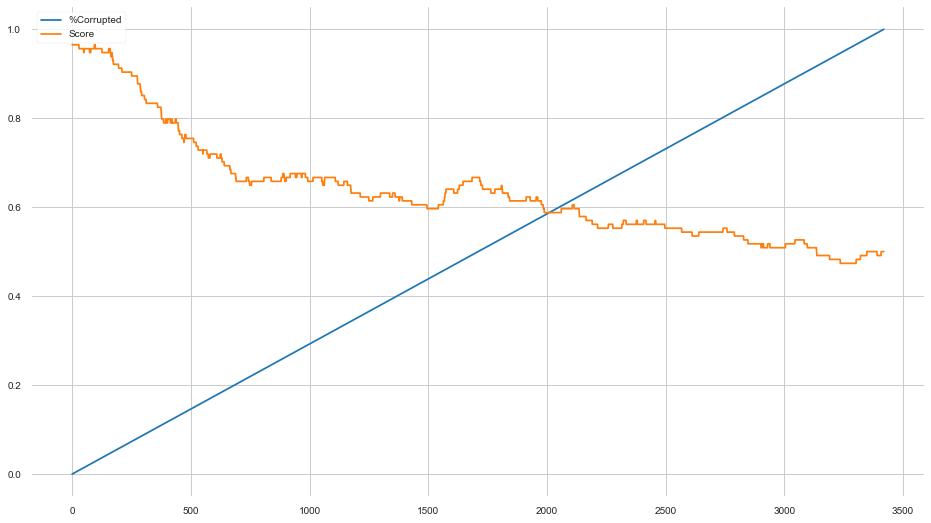

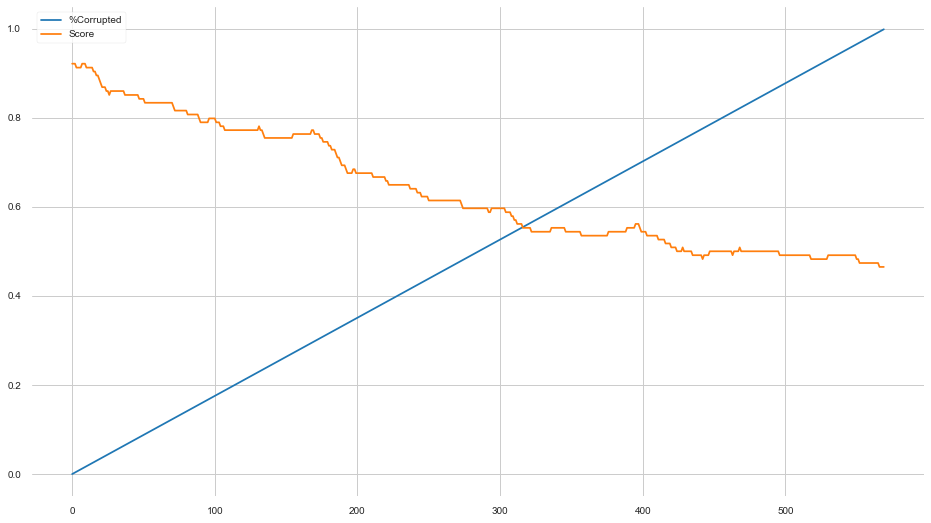

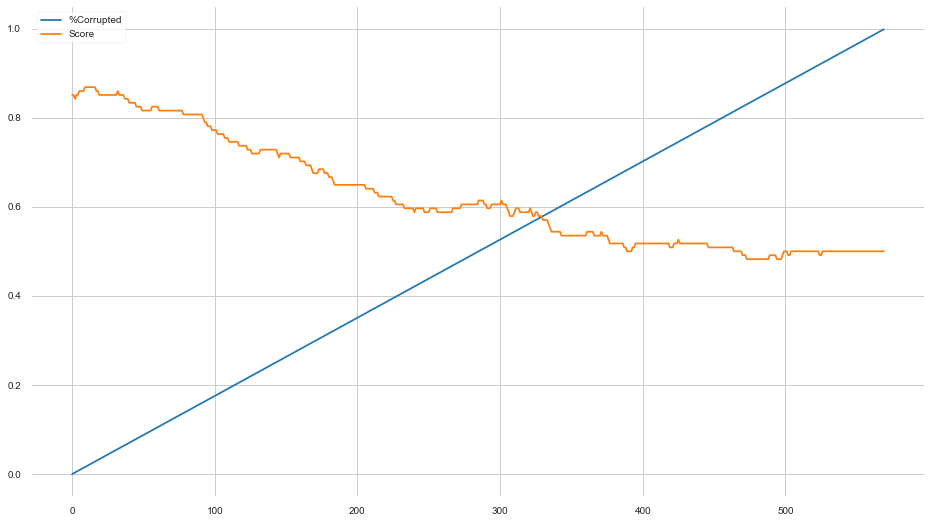

In [17]:
experiment_df.plot(figsize=(16,9),grid=True);
expeirment_df_rfe.plot(figsize=(16,9),grid=True);
experiment_df_5_error.plot(figsize=(16,9),grid=True);


In [36]:
class AccErrorSelection:
    def __init__(self,data,target,model=None):
        self.data = data.copy()
        self.target = target
        self.model = model
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(data,target, test_size=0.20)
        self.clean_test_baseline_score = self.measure_model_performance(self.X_train, self.X_test, self.y_train, self.y_test) #TODO: 
        
        self.error_test_baseline_score = self.measure_error_auc(self.get_pipeline(self.X_train).fit(self.X_train,self.y_train),
                                                                self.X_test,
                                                                self.y_test,
                                                                data.columns.tolist())
        
        self.best_acc_features = [] # List of features that has perfomed best wrt to accuracy of the model (or OLS)
        self.best_error_features = [] # List of features that hes perfomed best wrt to error score

    def measure_error_auc(self,clf,X_test,y_test,feature_cols):
    
        data_corruptor = DataCorruptor(X_test,feature_cols)
        total_cells = X_test.shape[0] * X_test.shape[1]
        res= []
        for n in range(total_cells):
                corrupted_score = clf.score(data_corruptor.get_dataset_with_corrupted_cell(), y_test)
                res.append([(n/total_cells),corrupted_score])
        df = pd.DataFrame(res,columns=['%Corrupted','Score'])

        #print('Area under the curve {}'.format(np.trapz(df['Score'],df['%Corrupted'])))
        return np.trapz(df['Score'],df['%Corrupted'])

        
    def measure_model_performance(self,X_train,X_test,y_train,y_test):
        """ This helping function is used to retrive the perfomnace of the the model for a given feature representation. 
            It does retrive the pipeline, fit it with train data and evaluate performance    
        """
        pipeline = self.get_pipeline(X_train)    
        pipeline.fit(X_train,y_train)
        return pipeline.score(X_test,y_test)
        
        
        
    def forward_selection(self,significance_level=0.05):
        initial_features = self.data.columns.tolist()
        best_features = []
        while (len(initial_features)>0):
            remaining_features = list(set(initial_features)-set(best_features))
            new_pval = pd.Series(index=remaining_features)
            for new_column in remaining_features:
                features_with_constant = sm.add_constant(self.data[best_features+[new_column]])
                model = sm.OLS(self.target, features_with_constant).fit()
                new_pval[new_column] = model.pvalues[new_column]
            min_p_value = new_pval.min()
            if(min_p_value<significance_level):
                best_features.append(new_pval.idxmin())
            else:
                break
        return best_features

        
    
    
    def backward_elimination(self,full_feature_list, significance_level = 0.05):
        features = full_feature_list 
        #TODO:Implement feature list 
        
        #for feature in full_feature_list:            
        #   if(self.error_test_baseline_score >= performance):
        #        features.remove(excluded_feature)

        return features

    def prepare_error_ranking(self,corruption_degree=0.95):
        """ This function creates the initial ranking for of the features.
            The ranking is created by corrupting every coolumn on by one and evaluation the perfomance drop for each corruption. 
            Corruption is parametrisable.
            corruption_degree type: int 
        """
        feature_stats = self.data.describe().T[['mean', 'std', 'max', 'min']]
        feature_cols = self.data.columns.to_list()
        data_corruptor = DataCorruptor(self.X_test,feature_cols,feature_stats)
        pipeline_model = self.get_pipeline(self.X_train,model=self.model)
        pipeline_model.fit(self.X_train,self.y_train)
        res_= []
        print('Feature Ranking Error')
        for idx,column in enumerate(feature_cols):
            corrupted_score = pipeline_model.score(data_corruptor.get_dataset_with_corrupted_col(column), self.y_test)
            loss = corrupted_score - self.clean_test_baseline_score
            res_.append([column,corrupted_score,loss])
            print("model score: %.3f" % corrupted_score)
        return res_
        
        
    def get_pipeline(self,X,model=None):
        """Get a sklearn pipeline that is adjusted to the dataset X """ 
        numeric_features = X.select_dtypes(include="number").columns.to_list()
        categorical_features = X.select_dtypes(include="object").columns.to_list()
        
        if model is None:
            model =LogisticRegression()
        #TODO: Make this funtion parametrisable so it takes numeric/categorical transofmers as parameters 
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)])

        clf= Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
          
        return clf
    
    

In [37]:
import statsmodels.api as sm
aes = AccErrorSelection(X,y)

aes.forward_selection()
    

['concave points_worst',
 'radius_worst',
 'texture_worst',
 'area_worst',
 'smoothness_se',
 'symmetry_worst',
 'compactness_se',
 'radius_se',
 'fractal_dimension_worst',
 'compactness_mean',
 'concave points_mean',
 'concavity_worst',
 'concavity_se',
 'area_se']

In [38]:
aes.prepare_error_ranking()

Feature Ranking Error
model score: 0.974
model score: 0.965
model score: 0.939
model score: 0.877
model score: 0.728
model score: 0.737
model score: 0.754
model score: 0.746
model score: 0.711
model score: 0.711
model score: 0.711
model score: 0.675
model score: 0.614
model score: 0.561
model score: 0.482
model score: 0.509
model score: 0.491
model score: 0.482
model score: 0.482
model score: 0.500
model score: 0.561
model score: 0.561
model score: 0.535
model score: 0.526
model score: 0.491
model score: 0.491
model score: 0.491
model score: 0.482
model score: 0.482
model score: 0.465


[['radius_mean', 0.9736842105263158, -0.00877192982456132],
 ['texture_mean', 0.9649122807017544, -0.01754385964912275],
 ['perimeter_mean', 0.9385964912280702, -0.04385964912280693],
 ['area_mean', 0.8771929824561403, -0.10526315789473684],
 ['smoothness_mean', 0.7280701754385965, -0.2543859649122806],
 ['compactness_mean', 0.7368421052631579, -0.24561403508771928],
 ['concavity_mean', 0.7543859649122807, -0.22807017543859642],
 ['concave points_mean', 0.7456140350877193, -0.23684210526315785],
 ['symmetry_mean', 0.7105263157894737, -0.27192982456140347],
 ['fractal_dimension_mean', 0.7105263157894737, -0.27192982456140347],
 ['radius_se', 0.7105263157894737, -0.27192982456140347],
 ['texture_se', 0.6754385964912281, -0.3070175438596491],
 ['perimeter_se', 0.6140350877192983, -0.36842105263157887],
 ['area_se', 0.5614035087719298, -0.42105263157894735],
 ['smoothness_se', 0.4824561403508772, -0.49999999999999994],
 ['compactness_se', 0.5087719298245614, -0.4736842105263157],
 ['concav

In [39]:
aes.error_test_baseline_score

0.6465643274853801

In [40]:
aes.clean_test_baseline_score

0.9824561403508771